In [1]:
# !pip install ../

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict

from nmt.vocab import get_src_vocab, get_trg_vocab
from nmt.dataset import TextDataset
# from nmt.nets.baseline_net import BasicNet
from nmt.config import TRAIN_SRC_PATH, TRAIN_TRG_PATH, \
        VAL_SRC_PATH, VAL_TRG_PATH, CONFIG

In [3]:
data_config = CONFIG["data"]
train_config = CONFIG["train"]

In [4]:
src_vocab = get_src_vocab(TRAIN_SRC_PATH, data_config)
trg_vocab = get_trg_vocab(TRAIN_TRG_PATH, data_config)
train_dataset = TextDataset(TRAIN_SRC_PATH, TRAIN_TRG_PATH, src_vocab, trg_vocab)
val_dataset = TextDataset(VAL_SRC_PATH, VAL_TRG_PATH, src_vocab, trg_vocab)

In [5]:
def plot_lens_hist(texts, perc = 95):
    lens = [len(text.split()) for text in texts]
    plt.hist(lens)
    plt.axvline(x=np.percentile(lens, perc), color='r')
    plt.legend([f'{perc}% percentile'])
    plt.show()
    print(f"{perc}% percentile:", np.percentile(lens, perc))

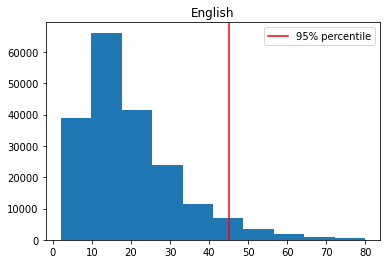

95% percentile: 45.0


In [6]:
plt.title("English")
plot_lens_hist(train_dataset.src_texts)

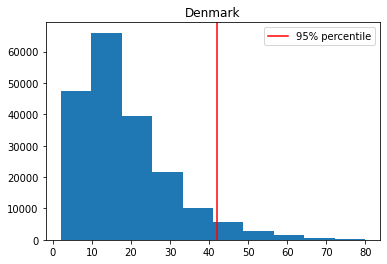

95% percentile: 42.0


In [7]:
plt.title("Denmark")
plot_lens_hist(train_dataset.trg_texts)

### Model

In [91]:
import torch
import torch.nn as nn


class BasicNet(nn.Module):
    def __init__(self, vocab, config):
        super().__init__()
        
        self.vocab = vocab
        self.eos_idx = vocab.word_to_idx[vocab._EOS]
        self.bos_idx = vocab.word_to_idx[vocab._SOS]
        n_tokens = vocab.vocab_size

        self.enc_emb = nn.Embedding(n_tokens, config["enc_emb_size"], self.eos_idx)
        self.enc_lstm = nn.LSTM(config["enc_emb_size"], config["enc_hid_size"], 2, batch_first=True)
        self.dec_emb = nn.Embedding(n_tokens, config["dec_emb_size"], self.eos_idx)
        self.dec_gru = nn.GRUCell(config["dec_emb_size"], config["dec_hid_size"])
        self.dec_fc = nn.Linear(config["dec_hid_size"], n_tokens)

    def forward(self, inp_tokens, out_tokens):
        """ Apply model in training mode """
        initial_state = self.encode(inp_tokens)
        return self.decode(initial_state, out_tokens)

    def encode(self, inp_tokens, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        # Shape: (batch_size, seq_len, emb_size)
        emb = self.enc_emb(inp_tokens.clone())  # TODO: Remove clone
        # Shape: (batch_size)
        lengths = (inp_tokens != self.eos_idx).to(torch.int64).sum(dim=1).clamp_max(inp_tokens.shape[1] - 1)
        # Shape: (batch_size, seq_len, hid_size)
        enc_seq, _ = self.enc_lstm(emb)
        # Shape: (batch_size, hid_size)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        return last_state

    def decode_step(self, prev_state, prev_tokens):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        # Shape: [batch_size, emb_size]
        prev_embs = self.dec_emb(prev_tokens)
        # Shape: [batch_size, hid_size]
        next_state = self.dec_gru(prev_embs, prev_state)
        # Shape: [batch_size, vocab_size]
        logits = self.dec_fc(next_state)

        return next_state, logits

    def decode(self, initial_state, out_tokens, **flags):
        """ 
        Iterate over reference tokens (out_tokens) with decode_step
        :param initial_state: Initial state for decoder with shape [batch_dize, hid_size]
        :param out_tokens: Output tokens, an int vector of [batch_size, seq_len]
        :return: A tensor with logits with shape [batch_size, seq_len, vocab_size]
        """
        batch_size = out_tokens.shape[0]
        state = initial_state

        logits_sequence = []
        for i in range(out_tokens.shape[1]):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state), initial_state.device
        state = initial_state
        
        outputs = [torch.full([batch_size], self.bos_idx, dtype=torch.int64, device=device)]
        # all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            # all_states.append(state)

        return torch.stack(outputs, dim=1)

    @property
    def name(self):
        return "baseline"


In [92]:
model = BasicNet(trg_vocab, train_config)

In [93]:
inp_tensor, out_tensor = train_dataset[0]
inp_tensor = inp_tensor.unsqueeze(0)
out_tensor = out_tensor.unsqueeze(0)

In [94]:
out_tensor.shape

torch.Size([1, 42])

In [95]:
enc_last_state = model.encode(inp_tensor)

In [96]:
out_tensor.shape

torch.Size([1, 42])

In [97]:
tmp = model.decode_step(enc_last_state, out_tensor[:, 0])

In [98]:
res = model.decode(enc_last_state, out_tensor)

In [99]:
model.decode_inference(enc_last_state)

tensor([[   1,  787, 2977, 2078, 3829, 1575, 3829, 1575, 4571, 1491, 4035, 2471,
          991,  869,  193, 3673, 3467, 4779, 4779,   73, 4035, 2195, 4486, 1701,
         2768,  193,  713, 3913, 4571, 1491, 4035, 2471,  991,  869,  193, 4015,
         1596,  713, 4566,  713, 4328,  193,  193,  907, 4063, 4779, 4779,   73,
         4035, 2195, 4486, 1701, 2768,  193,  713, 3913, 4571, 1491, 4035, 2471,
          991,  869,  193, 4015, 1596,  713, 4566,  713, 4328,  193,  193,  907,
         4063, 4779, 4779,   73, 4035, 2195, 4486, 1701, 2768,  193,  713, 3913,
         4571, 1491, 4035, 2471,  991,  869,  193, 4015, 1596,  713, 4566,  713,
         4328,  193,  193,  907, 4063]])

In [70]:
res.shape

torch.Size([1, 42, 5000])

In [12]:
import torch
import torch.nn as nn

In [13]:
class Encoder(nn.Module):
    def __init__(self, vocab, emb_size, hid_size):
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self.vocab = vocab
        self.eos_idx = vocab.word_to_idx[vocab._EOS]
        n_tokens = vocab.vocab_size
        self.emb = nn.Embedding(n_tokens, emb_size, self.eos_idx)
        self.lstm = nn.LSTM(emb_size, hid_size, 2, batch_first=True)
    
    def forward(self, inp):
        # Shape: (batch_size, seq_len, emb_size)
        emb = self.emb(inp.clone())
        # Shape: (batch_size, seq_len, hid_size)
        lengths = (inp != self.eos_idx).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        enc_seq, hidden = self.lstm(emb)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        
        return last_state

In [14]:
# encoder = Encoder(en_vocab)

In [15]:
# test_tensor = torch.from_numpy(train_en_idxs[0])
# test_tensor = test_tensor.unsqueeze(0)
# encoder(test_tensor).shape

In [16]:
class Decoder(nn.Module):
    def __init__(self, vocab, emb_size, hid_size):
        super().__init__()
        
        self.vocab = vocab
        self.eos_idx = vocab.word_to_idx[vocab._EOS]
        n_tokens = vocab.vocab_size
        self.emb = nn.Embedding(n_tokens, emb_size, self.eos_idx)
        self.gru = nn.GRU(emb_size, hid_size, batch_first=True)
        self.fc = nn.Linear(hid_size, n_tokens)
    
    def forward(self, inp, hidden):
        # Shape: (batch_size, seq_len, emb_size)
        emb = self.emb(inp.clone())
        
        output, _ = self.gru(emb, hidden.unsqueeze(0))
        output = self.fc(output)
        return output

In [17]:
# decoder = Decoder(de_vocab)

In [18]:
# enc_test_tensor = torch.from_numpy(train_en_idxs[0])
# enc_test_tensor = enc_test_tensor.unsqueeze(0)
# enc_hidden = encoder(enc_test_tensor)

# dec_test_tensor = torch.from_numpy(train_de_idxs[0])
# dec_test_tensor = dec_test_tensor.unsqueeze(0)
# logits = decoder(dec_test_tensor, enc_hidden)

In [19]:
import torch.nn.functional as F

def compute_mask(input_ix, eos_ix):
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, \
                 pad=(1, 0, 0, 0), value=True)


In [20]:
# compute_loss(encoder, decoder, enc_test_tensor, dec_test_tensor)

In [21]:
import wandb
wandb.init(config=CONFIG, project="dl_hse_nmt")

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [22]:
device = train_config["device"]

encoder = Encoder(en_vocab, train_config["enc_emb_size"], train_config["enc_hid_size"])
encoder = encoder.to(device)
decoder = Decoder(de_vocab, train_config["dec_emb_size"], train_config["dec_hid_size"])
decoder = decoder.to(device)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=train_config["lr"])

In [23]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(trans, real, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    return corpus_bleu(
        [[ref.split()] for ref in real],
        [trans.split() for trans in trans],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100




In [24]:
def translate(logits):
    pred_idxs = torch.argmax(logits, dim=2)
    pred_idxs = pred_idxs.detach().cpu().numpy()
    texts = []
    for text_idxs in pred_idxs:
        texts.append(de_vocab.decode(text_idxs))
    
    return texts

In [2]:
import numpy as np
np.__version__

'1.18.1'

In [25]:
for epoch in range(train_config["epochs_num"]):
    for idx, item in tqdm.tqdm(enumerate(train_dataloader)):
        inp, out = item
        inp = inp.to(device)
        out = out.to(device)
        
#         print("=="*30)
#         print(inp)
#         print(out)
        
        optimizer.zero_grad()
        
#         loss = compute_loss(encoder, decoder, inp, out)
        enc_out = encoder(inp)
        logits = decoder(out, enc_out)
        loss = compute_loss(logits, inp, out)
        
        loss.backward()
        optimizer.step()
        
        if idx % train_config["log_each"] == 0:
            with torch.no_grad():
                val_real_idxs = []
                val_translations = []
                for val_item in val_dataloader:
                    val_inp, val_out = val_item
                    val_inp = val_inp.to(device)
                    val_out = val_out.to(device)

                    val_enc_out = encoder(val_inp)
                    val_logits = decoder(val_out, val_enc_out)
                    val_loss = compute_loss(val_logits, val_inp, val_out)

                    val_real_idxs.append(val_out)
                    val_translations += translate(val_logits)

            val_real_idxs = torch.cat(val_real_idxs, dim=0)
            val_real_idxs = val_real_idxs.detach().cpu().numpy()
            val_real = de_vocab.decode_idxs(val_real_idxs)
            val_bleu = compute_bleu(val_translations, val_real)
            
            example_idxs = np.random.choice(range(len(val_dataset)), 10)
            examples_real = np.array(val_real)[example_idxs]
            examples_pred = np.array(val_translations)[example_idxs]
            examples = list(zip(examples_real, examples_pred))
            
            wandb.log({
                "Train loss": loss,
                "Val loss": val_loss,
                "Val bleu": val_bleu,
                "Examples": wandb.Table(data=examples, \
                                columns=["Real", "Translation"])
            })

3062it [00:47, 64.33it/s]
3062it [00:47, 63.99it/s]
3062it [00:47, 65.07it/s]
3062it [00:46, 66.44it/s]
3062it [00:46, 65.38it/s]
3062it [00:46, 65.32it/s]
3062it [00:46, 66.15it/s]
3062it [00:47, 64.98it/s]
3062it [00:46, 66.23it/s]
3062it [00:46, 66.33it/s]
3062it [00:46, 65.66it/s]
3062it [00:46, 66.16it/s]
3062it [00:46, 66.23it/s]
3062it [00:45, 66.61it/s]
3062it [00:47, 63.81it/s]
3062it [00:46, 65.45it/s]
3062it [00:45, 66.74it/s]
3062it [00:46, 65.28it/s]
3062it [00:46, 66.37it/s]
3062it [00:46, 65.87it/s]
3062it [00:46, 66.09it/s]
3062it [00:45, 67.00it/s]
3062it [00:46, 66.30it/s]
3062it [00:46, 66.44it/s]
3062it [00:47, 65.01it/s]
3062it [00:47, 65.15it/s]
3062it [00:46, 65.77it/s]
3062it [00:47, 64.92it/s]
3062it [00:47, 64.49it/s]
3062it [00:46, 65.62it/s]
3062it [00:46, 65.26it/s]
3062it [00:46, 65.90it/s]
3062it [00:46, 66.44it/s]
3062it [00:46, 65.73it/s]
3062it [00:46, 65.43it/s]
3062it [00:47, 63.81it/s]
3062it [00:46, 65.81it/s]
3062it [00:47, 65.10it/s]
3062it [00:4